In [ ]:
pip install numdifftools

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 100.2/100.2 kB 1.8 MB/s eta 0:00:00


In [ ]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import torch
from torch import nn
from math import *
import statistics as stat
from mpl_toolkits.mplot3d import Axes3D
from matplotlib import cm
from scipy.misc import derivative
import numdifftools as nd

In [ ]:
df = pd.read_csv("/content/house_price_madrid.csv",
                 index_col=False,
                 header=0)

#Preparacion de los datos

In [ ]:
print(len(df.loc[df["m2"]<=5].index))
df = df.drop(df.loc[df["m2"]<=10].index, axis=0)
df = df.drop_duplicates()

41


In [ ]:
df.shape

(14218, 9)

In [ ]:
data = {
    "x":df["m2"].tolist(),
    "y":df["price"].tolist()
}


print(len(data["x"]), len(data["y"]))
print(data['x'][:10],"...")
print(data['y'][:10],"...")

"""class leastSquaresGradient(): #Esta clase la guardo de recuerdo, es la misma que la que hay debajo pero sin optimizar
  def __init__(self, x, y, minIntercept, maxIntercept, minSlope, maxSlope ,accuracy = 100):
    self.y = y
    self.x = x
    self.intercept = np.linspace(0,1, num = accuracy)
    self.slope = np.linspace(0,1, num = accuracy)
    self.intercept, self.slope = np.meshgrid(self.intercept, self.slope)
    self.predicted_y = self.predictReg()
    self.ls = self.leastSq()
  def predictReg(self):
    x = np.ones(list(self.intercept.shape) + [len(self.x)]) * self.x
    return (self.intercept + (self.slope * x.transpose())).transpose()
  def leastSq(self):
    return sum((((self.y * np.ones(self.predicted_y.shape)) - self.predicted_y)**2).transpose())
  def print3dGraph(self):
    fig = plt.figure()
    ax = plt.axes(projection='3d')
    surface = ax.plot_surface(self.intercept, self.slope, self.ls,
                          cmap=cm.viridis,
                          rstride = 2,
                          cstride = 2)
    ax.set_xlabel('x = intercept')
    ax.set_ylabel('y = slope')
    ax.set_zlabel('rss')
    plt.show()"""


class LeastSquaresGradient():
    def __init__(self, x, y, minIntercept, maxIntercept, minSlope, maxSlope, accuracy=100):
        self.y = y
        self.x = x
        self.intercept = np.linspace(minIntercept, maxIntercept, num=accuracy)
        self.slope = np.linspace(minSlope, maxSlope, num=accuracy)
        self.intercept, self.slope = np.meshgrid(self.intercept, self.slope)
        self.predicted_y = self.predict_reg()
        self.ls = self.least_sq()
        minIdx = np.where(self.ls == self.ls.min())
        self.minInter = self.intercept[0][minIdx[1][0]]
        self.minSlope = self.slope[minIdx[0][0]][0]

    def predict_reg(self):
        return self.intercept[:, :, np.newaxis] + self.slope[:, :, np.newaxis] * self.x

    def least_sq(self):
        errors = self.y - self.predicted_y
        return np.sum(errors ** 2, axis=2)

    def print_3d_graph(self):
        fig = plt.figure()
        ax = fig.add_subplot(111, projection='3d')
        surface = ax.plot_surface(self.intercept, self.slope, self.ls, cmap=cm.viridis, rstride=2, cstride=2)
        ax.set_xlabel('Intercept')
        ax.set_ylabel('Slope')
        ax.set_zlabel('RSS')
        plt.show()

14218 14218
[118.0, 82.0, 72.0, 174.0, 75.0, 69.0, 54.0, 69.0, 129.0, 111.0] ...
[495000, 485000, 315000, 585000, 255000, 299000, 265000, 290000, 660220, 525000] ...


In [ ]:
df.describe().round()

,price,rooms,m2
count,14218.0,14218.0,14218.0
mean,606305.0,3.0,125.0
std,755985.0,1.0,103.0
min,725.0,1.0,20.0
25%,194000.0,2.0,66.0
50%,350000.0,3.0,92.0
75%,700000.0,3.0,140.0
max,11200000.0,17.0,989.0


#Variables estadísticas

La media tambien se puede llamar esperanza y se puede simbolizar como X con una raya arriba o como E[x]. De hecho E[x] tmabien puede significar que algo esta dividido por el numero de datos (igual que se hace la media).

###Desviación típica - *s, σ o dt*
Representada de manera abreviada por la letra griega minúscula sigma σ o la letra latina s, así como por las siglas SD es una medida que se utiliza para cuantificar la variación o la dispersión de un conjunto de datos numéricos. Una desviación estándar baja indica que la mayor parte de los datos de una muestra tienden a estar agrupados cerca de su media, mientras que una desviación estándar alta indica que los datos se extienden sobre un rango de valores más amplio. Es la raiz cuadrada de la varianza.

Para sacarla es necesaria la media, que es el sumatorio de todos los datos entre el numero de datos:
    
    x = [x_1, x_2, x_3...]
    media = sum(x)/len(x)
  
La desviación tipica es la raíz cuadrada del sumatorio de x menos la media al cuadrado dividido por el numero de datos:

    x = [x_1, x_2, x_3...]
    media = sum(x)/len(x)
    desviacion_tipica = sqrt(sum((x-media)**2)/len(x))



In [ ]:
xmedia = sum(data["x"])/len(data["x"])
dt_x = sqrt((sum((i-xmedia)**2 for i in data["x"]))/len(data["x"]))

ymedia = sum(data["y"])/len(data["y"])
dt_y = sqrt((sum((i-ymedia)**2 for i in data["y"]))/len(data["y"]))

print(
    "Media de x = ", xmedia,
    "\nDesviación típica de x = ", dt_x,
    "\nMedia de y = ", ymedia,
    "\nDesviación típica x = ", dt_y
    )

Media de x =  124.6633844422563 
Desviación típica de x =  102.79630874418191 
Media de y =  606305.2682515122 
Desviación típica x =  755958.7930726811


###Apuntamiento o curtosis
Es una característica de un conjunto de datos cuantitativos o de una distribución de probabilidad que indica la medida en la que los datos se acumulan en los extremos en relación a la acumulación de dichos datos en el centro de la distribución. Una curtosis grande implica un mayor número de valores de la variable muy dispersos y muy lejos del centro de la misma. No implica necesariamente una mayor varianza.

Se utiliza especialmente para probar o contrastar si el conjunto de datos proviene de una distribución normal, ya que la distribución normal tiene un nivel de curtosis exacto y fijo. Su formula es:

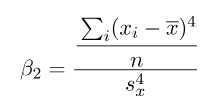

Al parecer es un carajal calcular la curtosis correctamente. Aqui abajo tambien pongo el histograma.

Curtosis de x:  17.35542408460006


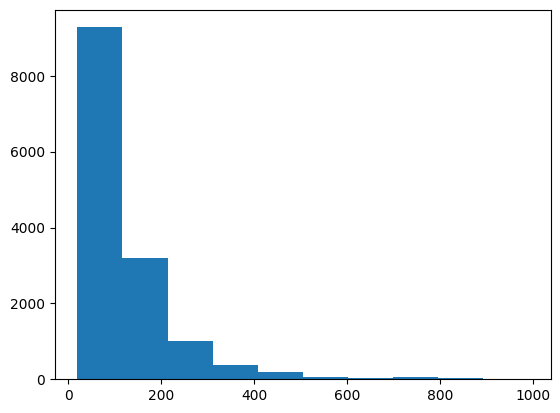

In [ ]:
plt.hist(data['x'])
curtosis_x = sum((i - xmedia)**4 for i in data['x'])/(len(data['x'])*(dt_x**4))
print("Curtosis de x: ", curtosis_x)

Curtosis de y:  27.964276708555794


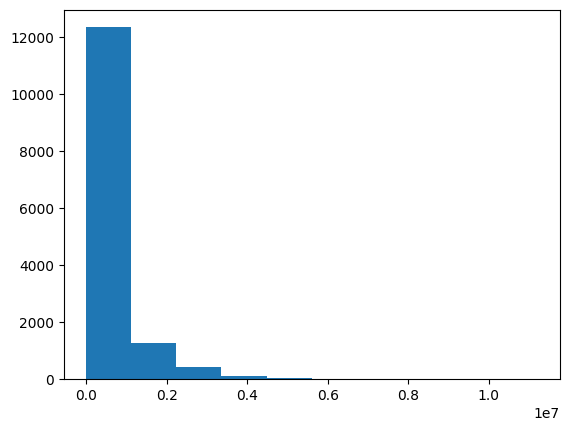

In [ ]:
plt.hist(data['y'])
curtosis_y = (sum((i - ymedia)**4 for i in data['y'])/len(data['y']))/(dt_y**4)-3
print("Curtosis de y: ", curtosis_y)

Curtosis de log(x):  17.35542408460006


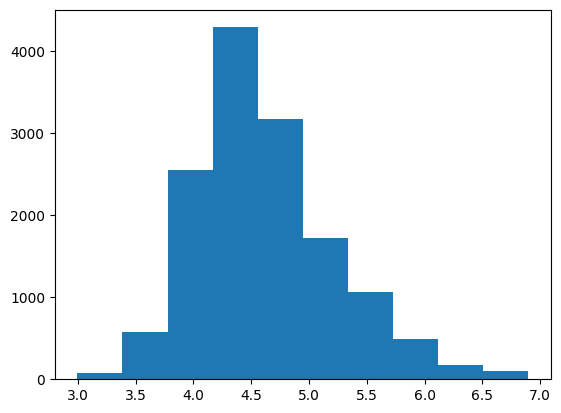

In [ ]:
#Igual conviene poner esto en una escala logaritmica
plt.hist([log(i) for i in data['x']])
print("Curtosis de log(x): ", curtosis_x)

###Error estándar - s_xmedia

Estimación de la cantidad que el valor de una estadística de prueba varía de muestra a muestra. Refleja la distancia media a la que se encuentran los coeficientes de regresión con respecto a los valores reales.

Cuando se ejecuta un análisis de regresión, se obtienen coeficientes que representan la relación entre cada predictor (variable independiente) y la variable de resultado (variable dependiente). El error estándar le da una idea de cuánto es probable que varíen estos coeficientes si recopilara nuevos datos y volviera a ejecutar el análisis. Un error estándar más pequeño significa que puede confiar más en las estimaciones de su modelo.

Es la desviacion tipica entre la raiz cuadrada del numero de datos:

    s/sqrt(len(data["x"]))

In [ ]:
s_xmedia = dt_x/sqrt(len(data['x']))
s_ymedia = dt_y/sqrt(len(data['y']))
print(
    "Error estándar de y: ", s_ymedia,
    "\nError estándar de x: ", s_xmedia
)

Error estándar de y:  6339.848326713542 
Error estándar de x:  0.8621012308556769


###Varianza - *s^2, σ^2 o dt^2*
Suele representarse como σ^2 o S^2 y es, literalmente la desviacion tipica al cuadrado (Mejor dicho, la desviacion tipica es la raiz cuadrada de la varianza). Hay que tener en cuenta que la varianza puede verse muy influida por los valores atípicos. Se puede decir que es la media de la distancia de cada valor a la media.

Al ser el cuadrado de la desviación típica la formula es igual pero sin la raíz cuadrada:

    x = [x_1, x_2, x_3...]
    media = sum(x)/len(x)
    varianza = sum((x-media)**2)/len(x)

In [ ]:
variance_x = (sum((i-xmedia)**2 for i in data["x"]))/len(data["x"])

variance_y = (sum((i-ymedia)**2 for i in data["y"]))/len(data["y"])

print(
    "\nVarianza de x = ", variance_x,
    "\nVarianza de y = ", variance_y
    )


Varianza de x =  10567.08109142917 
Varianza de y =  571473696823.9047


###Covarianza - *cov(x,y)*

La covarianza es un valor que indica el grado de variación conjunta de dos variables aleatorias respecto a sus medias. Es el dato básico para determinar si existe una dependencia entre ambas variables y además es el dato necesario para estimar otros parámetros básicos, como el coeficiente de correlación lineal o la recta de regresión. Este parametro determina si la variacion de una y de la otra estan relacionadas.

La covarianza de dos variables ("x" e "y") se puede hacer de la siguiente manera:

    cov_xy = sum((x - x_media)(y - y_media))/numero de datos

In [ ]:
cov_x_sobre_y = sum((i - xmedia)*(j - ymedia) for i,j in zip(data["x"], data["y"]))/len(data["x"])
print("Covarianza de x sobre y: ", cov_x_sobre_y)

Covarianza de x sobre y:  64361561.88801901


###Coeficiente de correlación - *r*
Cuantifica la intensidad de la relación lineal entre dos variables en un análisis de correlación. En los informes de correlación, este coeficiente se simboliza con la r.

La fórmula compara la distancia de cada dato puntual respecto a la media de la variable y utiliza esta comparación para decirnos hasta qué punto la relación entre las variables se ajusta a una línea imaginaria trazada entre los datos. Cuanto mas se acerca a 0 mas debil es la correlación, puede ser una relacion positiva (si r > 0) o negativa (si r < 0).

Esta relación se puede ver sesgada por datos atipícos y no aporta datos sobre relaciones curvilíneas.

El más común es el coeficiente producto-momento de Pearson.

el coeficiente de correlación de pearson es la covarianza de x e y partido entre el producto de la desviación tipica de x e y:

      cov_xy = sum((x - x_media)(y - y_media))/numero de datos
      s_x = sqrt(sum((x-xmedia)**2)/len(x))
      s_y = sqrt(sum((y-ymedia)**2)/len(y))
      r_xy = cov_xy/(s_x*s_y)

El coeficiente de determinacion (R2 o R cuadrado) es el que se usa en ML para determinar si hay o no una correlacion entre dos variavles, es simplemente el coeficiente de correlacion al cuadrado.

In [ ]:
#usando los valores de arriba
sx = sqrt(sum((i - xmedia)**2 for i in data["x"])/len(data["x"]))
sy = sqrt(sum((i - ymedia)**2 for i in data["y"])/len(data["y"]))
r_xy = cov_x_sobre_y/(sx*sy)
print("Coeficiente de correlación entre 'y' y 'x': ", r_xy,
      "\nCoeficiente de determinacion: ", r_xy**2)

Coeficiente de correlación entre 'y' y 'x':  0.8282299509703529 
Coeficiente de determinacion:  0.6859648516843532


###Percentiles
Un percentil es el valor de la variable por debajo del cual se encuentra un porcentaje dado de observaciones en un grupo. Por ejemplo, el percentil 20 es el valor bajo el cual se encuentran el 20 % de las observaciones, y el 80 % restante son mayores.

Se suelen poner como P seguido del numero del percentil (P25, P33, P70) o como cuartiles (Q1 = P25, Q2 = P50 = mediana, Q3 = P75)

In [ ]:
def percentile(percentil, sample):
  d, e = modf((percentil * len(sample))/100)
  sortedSample = sorted(sample)
  if d != 0:
    return sortedSample[int(e+1)]
  else:
    return (sortedSample[int(e)] + sortedSample[int(e+1)])/2

percentile(25,data["y"])

194000

#Recta de regresión

Modelo usado para aproximar al relacion de dependencia entre una (o más) variable independiente y otra dependiente. La recta de regresión siempre pasa por las coordenadas (xmedia, ymedia), que se llama el centro de gravedad

La recta de regresion tiene dos formas:
*   Forma punto pendiente
*   Forma desarrollada

la forma en punto pendiente de y sobre x se calcula:
    
    y-media(y) = covarianza/varianza * (x - media(x))

La forma punto-pendiente se puede desarrollar para acabar tal que:

    y = β0 + β1 * x

O, en caso de añadir el error:

    y = β0 + β1 * x + e

Dado que los parámetros β0 y β1son constantes desconocidas, estas deben estimarse mediante los datos de la muestra.

El residuo es la distancia desde el dato que hemos observado a la recta de regresión, es decir, cuanto se desvia el dato de la recta. Si es negativo significa que está por debajo o por detras de esta, y si es positivo esttá por encima o por delante.

###β1: Pendiente - *m* o *b*
La pendiente es β1 y es la covarianza partida de la varianza de x. Se puede representar como *m* como parametro descriptivo o como *b* o β1 si esta en la ecuación de la recta de regresión

###Error estandar de la pendiente - se_b
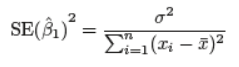

###β0: Intercept - *a*

Tambien llamada ordenada al origen, es el otro parametro de la forma explicita de la ecuación de la recta de regresión necesario para realizar la ecuación. Este es resultado del desarrollo de la ecuacion punto-pendiente al desarrollarla:

    ymedia = 7
    xmedia = 5
    m = 0.3
    y - ymedia = m(x - xmedia) --> y = m(x - xmedia) + ymedia --> sustituimos valores: y = 0.3(x - 5) + 7 --> y = 0.3x - 1.5 + 7 --> y = 0.3x + 5.5
    β0 = 5.5

se puede decir entonces que en la regresión lineal de x sobre y β0 es el producto de la pendiente (m) por la media de y sumado a la media de x:

    β0 = (m * (-ymedia)) + xmedia

que a su vez es:

    β0 = (cov(x, y) * varianza de y - ymedia) + xmedia

###Error estándar de intercept - se_a
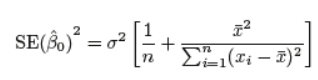

In [ ]:
#Recta de regresión de la edad(x) sobre la altura(y)
b = cov_x_sobre_y/variance_x
a = (b * (-xmedia)) + ymedia
print("intercept: ", a,"\nPendiente: ", b)

intercept:  -152989.57045829692 
Pendiente:  6090.760668073408


###Suma Residual de los cuadrados - RSS
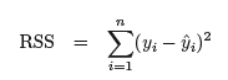

El residuo es la diferencia entre el valor observado y el valor predicho por nuestra recta. La suma residual de los cuadrados es el sumatorio de la diferencia entre los valores observados y los valores predichos y todo eso elevado al cuadrado, tal que:

    rss = sum((y_observado - y_predicho)**2 for i in range(0,len(data['y']-1)))

In [ ]:
rss_y = sum((j - (b*i+a))**2 for i,j in zip(data["x"], data['y']))
print("Suma residual de los cuadrados de la altura: ", rss_y) #Da una barbaridad porque mis datos fallan mas que una escopeta de feria

Suma residual de los cuadrados de la altura:  2551602476284800.5


###Error estándar residual - RSE
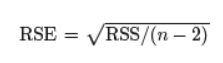

Mide la precisión con la que el modelo de regresión puede predecir valores con nuevos datos

In [ ]:
rse_y = sqrt(rss_y/(len(data['x'])-2))
print("Error estándar residual: ", rse_y)

Error estándar residual:  423660.32991849934


In [ ]:
nRandValues = 40
testData = {
    "x" : [np.random.randint(min(data['x']), high=max(data['x'])) for i in range(0, nRandValues)],
    "y" : []
}

for i in testData["x"]:
  testData["y"].append((b*i+a)+np.random.normal(scale=rse_y))
testData

{'x': [915,
  267,
  968,
  909,
  821,
  956,
  935,
  172,
  619,
  346,
  152,
  617,
  327,
  620,
  574,
  657,
  580,
  670,
  801,
  678,
  379,
  505,
  630,
  211,
  307,
  176,
  379,
  522,
  260,
  973,
  190,
  255,
  871,
  215,
  715,
  581,
  954,
  211,
  349,
  107],
 'y': [5664640.279589582,
  1359546.6928618513,
  5947167.895768823,
  5660434.483040066,
  5615317.471411995,
  5846193.84066032,
  5831205.056491758,
  1629257.7881043812,
  4162490.2426574873,
  1833693.320318065,
  1484432.2763534146,
  3421864.0260575875,
  1973909.8522486042,
  3178011.7379839304,
  3874604.9332801467,
  4100344.2923686183,
  3769388.3216619673,
  3612985.4930297704,
  5151772.691087196,
  3261994.3918291237,
  1201808.838614178,
  2936061.6942890747,
  3310740.4924823544,
  1504704.5611405903,
  1633115.9482044626,
  1051998.5643003832,
  1272757.9885833166,
  2983296.473240745,
  1347061.8055622363,
  5391596.913694063,
  1096474.3766810955,
  2127817.522314559,
  4622401.42248221

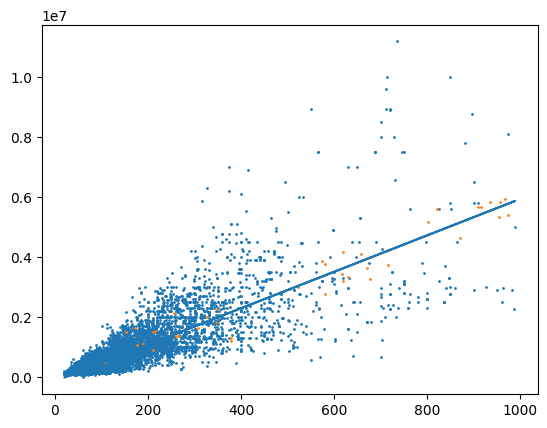

In [ ]:
plt.scatter(data["x"], data["y"], s=1)
plt.plot(data['x'], [b*i+a for i in data['x']])
plt.scatter(testData["x"], testData["y"], s=1) #Probando la recta de regresión con valores aleatorios para la edad
ax = plt.gca()
ax.get_yaxis().get_major_formatter().set_useOffset(False)
plt.show()

##Recta de regresión polinómica

Se usa cuando los datos no se adaptan a una linea recta, sino que puede que la covarianza varíe respecto a una de las variables. Esto lo pongo usando metodos de librerias y tal, que es bastante mas complicado.

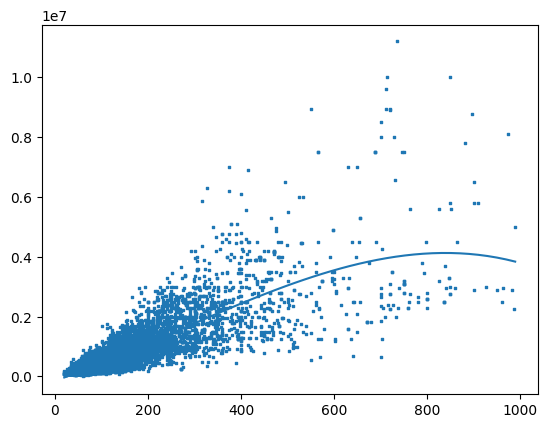

In [ ]:
mymodel = np.poly1d(np.polyfit(data['x'], data['y'], 3))
myline = np.linspace(min(data['x']), max(data['x'])) #Genera numeros en intervalos regulares desde "start" hasta "stop"
plt.scatter(data['x'], data['y'], marker="s", s=1)
plt.plot(myline, mymodel(myline))
plt.show()

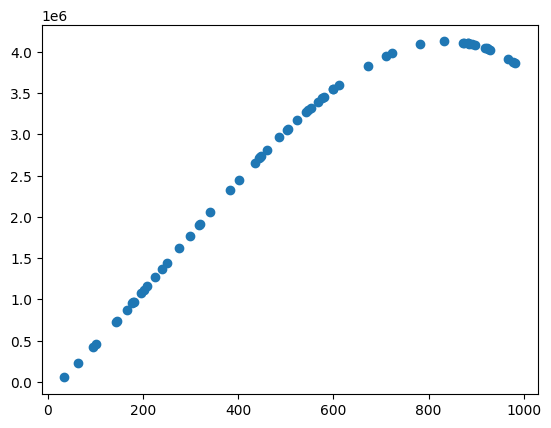

In [ ]:
testAge = np.random.randint(min(data['x']), high=max(data['x']), size=60)
plt.scatter(testAge, mymodel(testAge))

##Regresión múltiple

Para la regresion multiple voy a usar otro dataset, porque el que tenia al principio no es muy bueno.

Lo primero que hay que hacer es calcular el coeficiente de determinación del modelo multivariable



In [ ]:
covariance =  lambda x, y: sum((x - stat.mean(x))*(y - stat.mean(y)))/len(x)
var = lambda x: sum((x-stat.mean(x))**2)/len(x)
s = lambda x: sqrt(var(x))
r = lambda x, y: covariance(x,y)/(s(x)*s(y))
det = lambda x, y: r(x,y)**2

"""multReg = { "y" : pd.read_csv("/content/Student_Performance.csv",index_col=False, header=0)["Performance Index"].to_numpy(dtype = np.double),
            "x" : pd.read_csv("/content/Student_Performance.csv",index_col=False, header=0)["Hours Studied"].to_numpy(dtype = np.double),
            "z" : pd.read_csv("/content/Student_Performance.csv",index_col=False, header=0)["Previous Scores"].to_numpy(dtype = np.double)
           }"""

dataW_x = 0.6
dataW_z = 0.35
intercept_data = 24
multReg ={
    "x" : np.linspace(0, 42, num = 100),
    "z" : np.linspace(1, 20, num = 100),
}

multReg.update({"y" : intercept_data + dataW_x*multReg["x"] + dataW_z*multReg["z"]})

print(f"""Coeficiente de correlacion entre rendimiento y horas estudiadas {r(multReg["x"], multReg["y"])}
Coeficiente de Determinacion entre rendimiento y horas estudiadas {det(multReg["x"], multReg["y"])}
Coeficiente de correlacion entre rendimiento y notas pasadas {r(multReg["z"], multReg["y"])}
Coeficiente de determinacion entre rendimiento y notas pasadas {det(multReg["z"], multReg["y"])}
      """)


Coeficiente de correlacion entre rendimiento y horas estudiadas 1.0000000000000002
Coeficiente de Determinacion entre rendimiento y horas estudiadas 1.0000000000000004
Coeficiente de correlacion entre rendimiento y notas pasadas 1.0000000000000002
Coeficiente de determinacion entre rendimiento y notas pasadas 1.0000000000000004
      


Ahora puedo usar lo que se de redes neuronales para averiguar los coeficientes y la pendiente entre las multiples variables. Lo primero es dividir los datos en train y test.

In [ ]:
split_point = int(0.8 * len(multReg["x"]))
x_train, y_train, z_train = multReg["x"][0:split_point], multReg["y"][0:split_point], multReg["z"][0:split_point]
x_test, y_test, z_test = multReg["x"][split_point:], multReg["y"][split_point:], multReg["z"][split_point:]
len(x_train), len(y_train), len(y_test), len(x_test)
torch.manual_seed(236264)

In [ ]:
class LinearRegMultiModel(nn.Module):
  def __init__(self, *args, **kwargs) -> None:
    super().__init__(*args, **kwargs)
    self.weightx = nn.Parameter(torch.randn(1, requires_grad=True, dtype=torch.float))
    self.weightz = nn.Parameter(torch.randn(1, requires_grad=True, dtype=torch.float))
    self.bias = nn.Parameter(torch.randn(1, requires_grad=True, dtype=torch.float))
    self.double()

  #Metodo para definir la computacion del modelo
  def forward(self, x: torch.Tensor, z: torch.Tensor)->torch.Tensor: #X es los datos de entrenamiento
    return self.weightx * x + self.weightz * z + self.bias #<-- recta de regresión

def plot_predict3d(x_train, y_train, z_train, x_test, y_test, z_test, predictions = None):
      fig = plt.figure()
      ax = fig.add_subplot(111, projection='3d')
      ax.scatter(x_train, y_train, z_train, label = "training")
      ax.scatter(x_test, y_test, z_test, label = "testing")
      if predictions != None:
        plt.scatter(x_test, predictions,z_test, c="r", label="Predictions")
      plt.legend(prop={"size":14})
      plt.show()

def plot_predict(x_train, y_train, z_train, x_test, y_test, z_test, predictions = None):
  plt.scatter(x_train, y_train, c="b", s=4, label="Training Data")
  plt.scatter(x_test, y_test, c="g", s=4, label="Test Data")
  if predictions != None:
    plt.scatter(x_test, predictions, c="r", s=4, label="Predictions")
  plt.legend(prop={"size":14})

multivar_model = LinearRegMultiModel()
loss_fn = nn.MSELoss()
optimizer = torch.optim.SGD(params=multivar_model.parameters(), lr=0.0001)
print(multivar_model.state_dict())

OrderedDict([('weightx', tensor([-1.3658], dtype=torch.float64)), ('weightz', tensor([0.8953], dtype=torch.float64)), ('bias', tensor([-1.7777], dtype=torch.float64))])


Ya he inicializado el modelo y esas cosas y ahora toca entrenarlo para ver como va.

tensor(20.2906, dtype=torch.float64, grad_fn=<MseLossBackward0>)


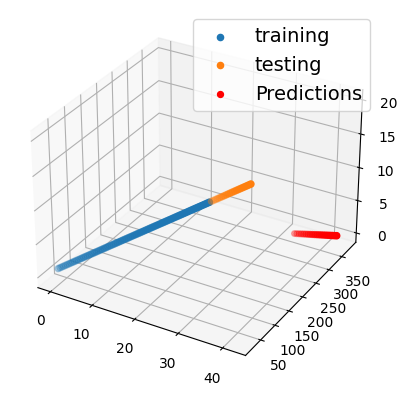

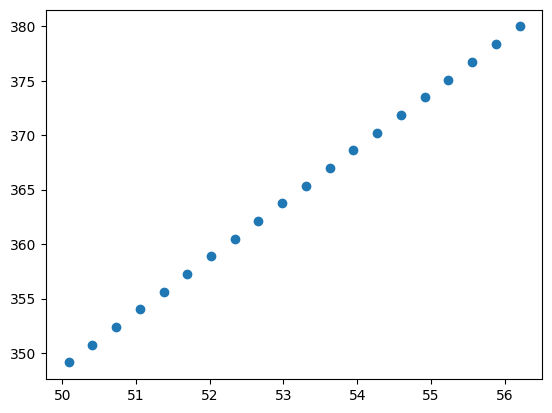

OrderedDict([('weightx', tensor([-2.7903], dtype=torch.float64)),
             ('weightz', tensor([8.7274], dtype=torch.float64)),
             ('bias', tensor([6.6988], dtype=torch.float64))])

In [ ]:
for i in range(1000):
  multivar_model.train()
  #1. Forward
  y_prediction = multivar_model(torch.from_numpy(x_train), torch.from_numpy(z_train))
  #2. Funcion de error
  loss = loss_fn(y_prediction, torch.from_numpy(y_train))
  #3. Optimizer 0grad
  optimizer.zero_grad()
  #4. Backpropagation
  loss.backward()
  #5. Optimizar los valores
  optimizer.step() #Los cambios en los parametros que realiza el optimizador se acumulan si se ejecutan varias veces, de ahi que se restablezcan en el paso 3

  multivar_model.eval()

print(loss)
y_prediction = multivar_model(torch.from_numpy(x_test), torch.from_numpy(y_test))
with torch.inference_mode():
  plot_predict3d(x_train,y_train, z_train, x_test, y_test, z_test, predictions = y_prediction)
  plt.scatter(y_test, y_prediction)
  plt.show()
multivar_model.state_dict()

In [ ]:
max(y_prediction)
m_x = multivar_model.state_dict()["weightx"][0].item()
m_z = multivar_model.state_dict()["weightz"][0].item()
inter = multivar_model.state_dict()["bias"][0].item()
m_x, m_z, inter

(1.3041397424192505, 0.7135781327009392, 0.43890256649879583)

(0.0, 100.0)

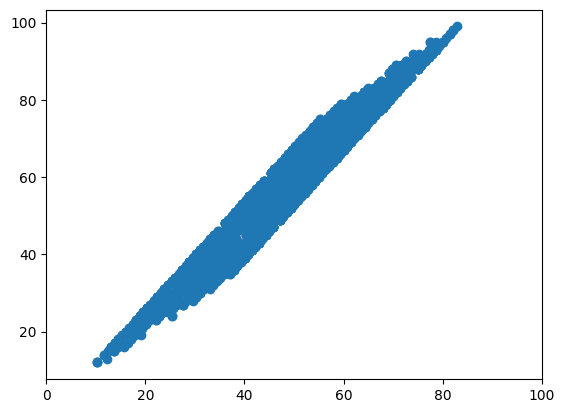

In [ ]:
plt.scatter(y_prediction.detach().numpy(), y_test)
ax = plt.gca()
ax.set_xlim(0, 100)

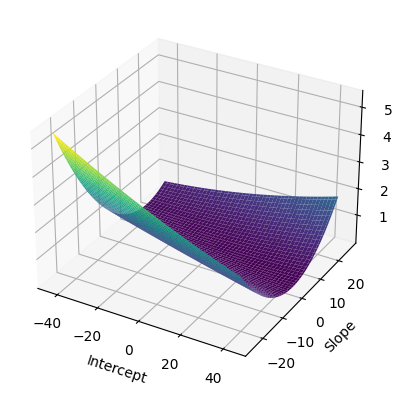

317.7821630951471
min Bias: 40.36130268085896
      min weight: 2.9639539600437494
      


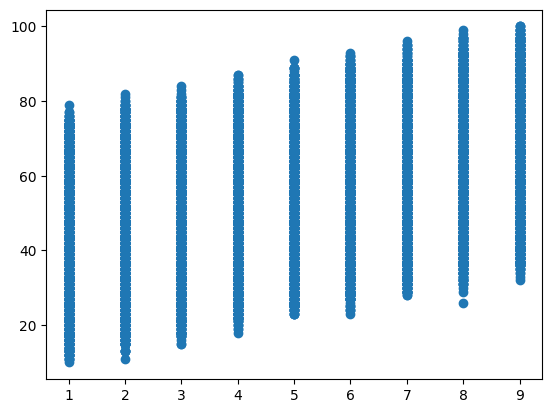

In [ ]:
#A ver como varia el error en función los parametros en un grafico 3d
mul_m = 20
mul_int = 100
gradient_x = LeastSquaresGradient(multReg['x'], multReg["y"], inter-mul_int*inter, inter*mul_int, m_x-mul_m*m_x, m_x*mul_m)
gradient_x.print_3d_graph()
print(gradient_x.ls.min()/len(multReg['x']))
print(f"""min Bias: {gradient_x.minInter}
      min weight: {gradient_x.minSlope}
      """)
plt.scatter(multReg['x'], multReg["y"])
plt.show()

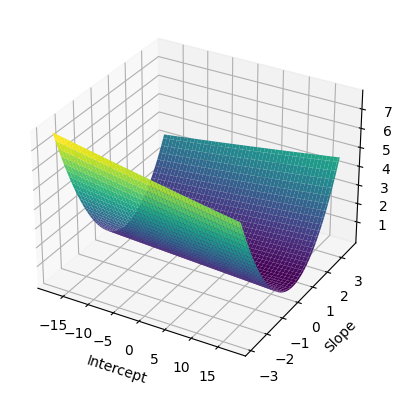

60.12480269036895
min Bias: -16.84676517874166
      min weight: 1.0379318293831843
      


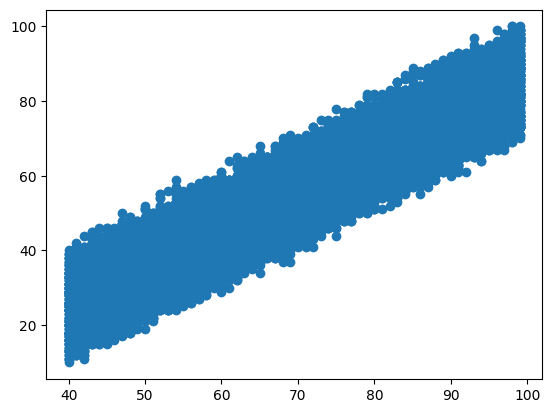

In [ ]:
#A ver como varia el error en función los parametros en un grafico 3d
mul_m = 5
mul_int = 40
gradient_x = LeastSquaresGradient(multReg['z'], multReg["y"], -mul_int*inter, inter*mul_int, m_z-mul_m*m_z, m_z*mul_m)
gradient_x.print_3d_graph()
print(gradient_x.ls.min()/len(multReg['x']))
print(f"""min Bias: {gradient_x.minInter}
      min weight: {gradient_x.minSlope}
      """)
plt.scatter(multReg['z'], multReg["y"])
plt.show()

Realmente no tengo datos para contrastar los resultados asi que no sé si el la regresión es correcta o tengo algun error en algun paso. Sin embargo los datos de regresión simple de cada muestra por separado (es decir, la regresion simple de horas estudiadas sobre resultados y la de resultados previos sobre resultados) evidencian que las horas estudiadas son mas determinantes para el resultado final que los resultados previos, lo cual tambien se muestra en la regresión multiple.

##Logistic Regression

Es un análisis de clasificación utilizado para predecir el resultado de una variable categórica en función de las variables independientes o predictoras. Es útil para modelar la probabilidad de un evento ocurriendo en función de otros factores.

Puede usarse para tratar de correlacionar la probabilidad de una variable cualitativa binaria (asumiremos que puede tomar los valores reales "0" y "1") con una variable escalar x. La idea es que la regresión logística aproxime la probabilidad de obtener "0" o "1" con el valor de la variable explicativa x. La probabilidad se aproxima mediante la funcion logistica

##Función logística
Es una función matemática que aparece en diversos modelos de crecimiento de poblaciones, propagación de enfermedades epidémicas y difusión en redes sociales.

    P(t) = 1/(1+e^-t)



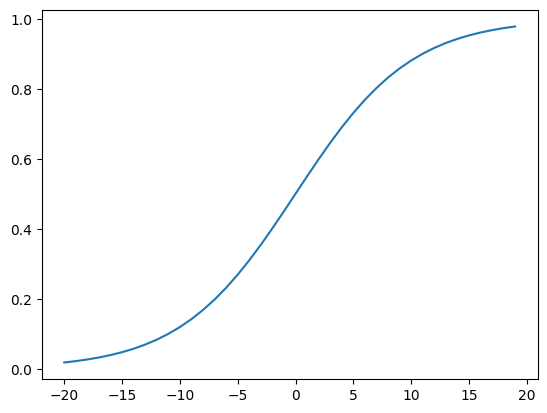

In [ ]:
logF = lambda t: 1/(1+e**-t)
d = {"x" : [i for i in range(-20,20)]}
d.update({"y" : [logF(i/5) for i in d["x"]]})
plt.plot(d["x"], d["y"])
plt.show()

Uno de los problemas con el que nos encontramos cuando la aplicamos al ML viniendo de aplicar modelos de recta de regresión es calcular el error para ajustar los parametros de nuestro modelo, porque no podemos usar la suma residual de los cuadrados. Para eso usamos "Maximum likelihood"

###Maximum likelihood
Su proposito es optimizar la distribucion de los datos. Para esto tenemos que comprobar a que tipo de distribución se asemejan nuestros datos

In [ ]:
"""logReg_y = pd.read_csv("/content/LGsocialNet.csv",
                 index_col=False,
                 header=0)["Purchased"].to_numpy()
logReg_x = pd.read_csv("/content/LGsocialNet.csv",
                 index_col=False,
                 header=0)["EstimatedSalary"].to_numpy()
plt.scatter(logReg_x, logReg_y, s=2)"""

FileNotFoundError: [Errno 2] No such file or directory: '/content/LGsocialNet.csv'

#Contraste de hipótesis - p

# Probabilidad


##Distribución de probabilidad
La distribución de probabilidad de una variable aleatoria es una función que asigna a cada suceso definido sobre la variable, la probabilidad de que dicho suceso ocurra. La distribución de probabilidad está definida sobre el conjunto de todos los sucesos y cada uno de los sucesos es el rango de valores de la variable aleatoria.

Tipos de variables:

* Variable aleatoria: Es aquella cuyo valor es el resultado de un evento aleatorio. Lo que quiere decir que son los resultados que se presentan al azar en cualquier evento o experimento.
* Variable aleatoria discreta: Es aquella que solo toma ciertos valores (frecuentemente enteros) y que resulta principalmente del conteo realizado.
* Variable aleatoria continua: Es aquella que resulta generalmente de la medición y puede tomar cualquier valor dentro de un intervalo dado

Las distribuciones de dividen en funcion del tipo de variable a estudiar:

Variable discreta (Distribuciones discretas con numeros enteros):

  * Distribución binomial (eventos independientes).
  * Distribución de Poisson (eventos independientes).
  * Distribución hipergeométrica (eventos dependientes).

Variables continuas (Distribuciones continuas con numeros reales):

  * Distribución normal o gaussiana.
  * Distribución de Cauchy
  * Distribución exponencial



La distribución de probabilidad está completamente especificada por la función de distribución, cuyo valor en cada x real es la probabilidad de que la variable aleatoria sea menor o igual que x.

la **función de distribución acumulada** o función de probabilidad acumulada asociada a una variable aleatoria real X sujeta a cierta ley de distribución de probabilidad, **es una función matemática de la variable real x que describe la probabilidad de que X tenga un valor menor o igual que x**. Realmente es el sumatorio de las probabilidades de todos los elementos por detrás de x (inclusive x). La importancia de la funcion de distribución acumulada reside en que permite calcular la posibilidad dentro de un intervalo en vez de en un valor en concreto. La FDA incluye el numero en el que se situa x.

La **función de probabilidad** es una función que devuelve la probabilidad de que una variable aleatoria discreta sea exactamente igual a algún valor.

##Distribuciones discretas

###Ensayo de Bernoulli
En ensayo de Bernoulli es un experimento aleatorio en el que sólo se pueden obtener dos resultados (habitualmente etiquetados como éxito y fracaso).

Si p es la probabilidad de éxito, entonces el valor del valor esperado (Esperanza) de la variable aleatoria es p y su varianza, p (1-p).

###Distribución de Bernoulli
Es una distribución de probabilidad discreta, dónde el valor 1 (éxito) ocurre con la probabilidad p y el valor 0  (fracaso) con la probabilidad q = 1 − p.

Un experimento al cual se aplica la distribución de Bernoulli se conoce como Ensayo de Bernoulli.

X es una variable aleatoria discreta que mide el numero de exitos y se realiza un unico experimento con dos posibles outputs.

In [ ]:
#Ejemplo: Se lanza un dado y se quiere hallar la probabilidad de que salga un 6.
resultadosPosibles = [1,2,3,4,5,6]
#Asumiendo que solo calculemos la probabilidad de uno de los seis resultados: p(x) = 1/len(resultadosPosibles)
x = [1]

p_x = len(x)/len(resultadosPosibles)

print(f"La probabilidad de que salga {x} es de {p_x}")
print(f"La probabilidad de que no salga {x} es de {1-p_x}")

La probabilidad de que salga [1] es de 0.16666666666666666
La probabilidad de que no salga [1] es de 0.8333333333333334


###Distribución geométrica
La distribución geométrica es cualquiera de las dos distribuciones de probabilidad discretas siguientes:

  * Si X = { 1 , 2 , … } es el número necesario para obtener un éxito.
  * Si X = { 0 , 1 , 2 , … } es el número de fracasos antes del primer éxito.

Es decir, mide la cantidad de intentos necesarios para obtener un éxito. La variable aleatoria X se usa para modelar el numero total de intentos hasta conseguir el primer exito en una sucesion de eventos intepentientes de tipo bernoulli.

Su función de probabilidad es:
P(X = x) = p*(1-p) ** (x-1)

Su funcion de distribucion acumulada es:
P(X <= x) = 1-(1-p)**x <-- es la forma desarrollada

La forma sin desarrollar es:

    x = [1,2,3...]
    P(X <= x) = sum(p(1-p)**i-1 for i in range(1, x+1))


In [ ]:
#Por ejemplo: Probabilidad de que lanzando un dado salga el numero 6 en la decima tirada
p = 1/6
x = 10
p_x = p*(1-p)**(x-1)
fda_x = sum(p*(1-p)**(i-1) for i in range(1, x+1))

print(f"La probabilidad de que el numero 6 salga por primera vez en la decima tirada es de {p_x*100}% \ny su funcion de distribución es {fda_x}, lo que quiere decir que hay un {fda_x*100}% de \nprobabilidades de que ya se hada dado el suceso")

La probabilidad de que el numero 6 salga por primera vez en la decima tirada es de 3.2301116577969156% 
y su funcion de distribución es 0.8384944171101543, lo que quiere decir que hay un 83.84944171101543% de 
probabilidades de que ya se hada dado el suceso


In [ ]:
#Cual es la probabilidad de que al lanzar un dado el numero 5 salga por primera vez despues de la septima tirada
x = 7
fda_x = sum(p*(1-p)**(i-1) for i in range(1, x+1))
print(f"La probabilidad de que el 5 salga por primera vez a la septima tirada o posterior es de {round((1-fda_x)*100, 2)}%")

La probabilidad de que el 5 salga por primera vez a la septima tirada o posterior es de 27.91%


###Distribucion Binomial

La distribución binomial se utiliza con frecuencia para modelizar el número de aciertos en una muestra de tamaño n extraída con reemplazo de una población de tamaño N. Cuenta el número de éxitos en una secuencia de n ensayos de Bernoulli independientes entre sí con una probabilidad fija p de ocurrencia de éxito entre los ensayos. Descrita por dos parámetros: n el número de experimentos realizados, y p la probabilidad de éxito.

En esta fórmula interviene el coeficiente binomial.

Funcion de probabilidad:
P(X = x) = (n, x) (p^x) * (1-p)^(n-x)

n = numero de ensayos o pruebas

p = probabilidad de exito

x = numero de exitos, que realmente es la variable que queremos despejar

(n, x) es un numero combinatorio, que da un poco por saco.
(n, x) = n!/x!*(n-x)!

numero! es un numero factorial

La funcion de distribucion acumulada de una distribucion binomial es:
P(X <= x) = sum((n, k)*(p^k) * (1-p)^(n-k))

k = numero iterador, como i en un for.


In [ ]:
#Ejemplo: Probabilidad de que en 20 tiradas de un dado 5 de ellas sean 6
p = 1/6
n = 20
x = 5
p_x = (factorial(n)/(factorial(x)*factorial(n-x))) * (p**x) * (1-p)**(n-x)
print(f"Hay un {round(p_x*100, 2)}% de probabilidad de que 5 de cada 20 tiradas de un dado sean seises")

Hay un 12.94% de probabilidad de que 5 de cada 20 tiradas de un dado sean seises


In [ ]:
#Ejemplo FDA: Probabilidad de que de 50 tiradas de un dado el numero 1 salga mas de 17 veces
n = 50
x = 17
fda_x = sum([factorial(n)/(factorial(k)*factorial(n-k)) * (p**k) * (1-p)**(n-k) for k in range(0, x+1)] )
print(f"La probabilidad de que despues de 50 tiradas de un dado el numero uno salga mas de 17 veces es de {round((1-fda_x)*100, 4)}%")

La probabilidad de que despues de 50 tiradas de un dado el numero uno salga mas de 17 veces es de 0.077%


###Distribución hipergeometrica

La distribución hipergeométrica es una distribución de probabilidad discreta relacionada con muestreos aleatorios y sin reemplazo. Sin reemplazo quiere decir que despues de tomar la muestra no se devuelve y se aparta, es decir, al tomar una muestra esa muestra no puede volver a aparecer. En esta distribución los ensayos no son independientes.

Si función de probabilidad es:
P(X = x) = ((k, x)*(N - k, n - x))/(N, n)

k = exitos posibles

N = total de eventos posibles al inicio

n = muestra, cuantos eventos se toman como muestra

x = valor a tomar por la variable aleatoria

Es decir, n es los eventos que realizamos y x es los exitos que queremos


In [ ]:
#Ejemplo, tenemos 3 coches blancos y 5 negros. ¿cual es la probabilidad de que al escoger tres coches aleatoriamente dos de ellos sean negros?
k = 5
N = 8
n = 3
x = 2
p_x = ((factorial(k)/(factorial(x)*factorial(k-x)))*(factorial(N-k)/(factorial(n-x)*factorial((N-k)-(n-x)))))/(factorial(N)/(factorial(n)*factorial(N-n)))
print(f"La probabilidad de que al coger tres coches dos de ellos sean negros es de {round(p_x*100, 2)}%")

La probabilidad de que al coger tres coches dos de ellos sean negros es de 53.57%


###Distribucion binomial negativa

La Distribución Binomial Negativa es una distribución de probabilidad discreta que incluye a la distribución de Pascal. Es una ampliación de las distribuciones geométricas, utilizada en procesos en los cuales se ve necesaria la repetición de ensayos hasta conseguir un número de casos favorables (primer éxito).

Una variable aleatoria geométrica corresponde al número de ensayos Bernoulli necesarios para obtener el primer éxito. Si deseamos conocer el número de estos para conseguir n éxitos, la variable aleatoria es binomial negativa.

Este proceso consta de varias condiciones:

  1. El proceso tiene un número indefinido de pruebas y este concluirá cuando se tenga un número determinado de resultados favorables **r**.
  2. Las pruebas pueden dar dos resultados posibles y excluyentes a su vez, es decir, A y no A.
  3. La probabilidad de obtener un resultado A en las pruebas es p, y la de conseguir no A es q, de forma que p + q = 1.
  4. p y q son constantes en cada prueba y a su vez estas son independientes.
  5. Derivación de la distribución: si la variable aleatoria X es "el número de pruebas necesarias para conseguir x éxitos o resultados A " ; entonces X seguirá una distribución binomial negativa con parámetros p y r.

  ¿Su funcion de probabilidad es: P(X = x) = (r + x - 1, x) * (p^r) * (1-p)^x?

  Por lo que parece la buena es: (x-1, r-1)*(p^r)(1-p)^(x-r)

  donde:

  r = numero de exitos deseado
  x = numero de ensayos necesarios para r exitos
  p = probabilidad de exito

In [ ]:
#Ejemplo: Una enfermedad tiene una probabilidad de 0.1 de aparecer en un humano.
#         ¿Cual es la posibilidad de que 4 personas tengan que ser analizadas para encontrar dos casos?
p = 0.1
r = 2
#p_x1 = lambda x: (factorial(r+x-1)/(factorial(x) * factorial((r+x-1) - x))) * (p**r) * ((1-p)**x)
p_x2 = lambda x: (factorial(x-1)/(factorial(r-1) * factorial(((x-1)-(r-1))))) * (p**r) * (1-p)**(x-r) #Esta es la buena, por lo que parece
print("Respuesta 1: ", p_x2(4))

#         ¿Cual es la probabilidad de que 5 o mas personas tengan que ser analizadas para encontrar dos casos?
print("Respuesta 2: ", (1 - sum(p_x2(i) for i in range(2, 5))))


Respuesta 1:  0.024300000000000006
Respuesta 2:  0.9477


###Distribucion logaritmica

###Distribucion beta binomial

 La distribución beta-binomial es una familia de distribuciones discretas de probabilidad sobre un dominio finito de enteros no negativos que surgen cuando la probabilidad de éxito en cada uno de un número fijo o conocido de ensayos de Bernoulli es desconocida o aleatoria. La distribución beta-binomial es la distribución binomial en la que la probabilidad de éxito en cada ensayo no es fija sino aleatoria y sigue la distribución beta. Se utiliza con frecuencia en la estadística bayesiana, métodos empíricos de Bayes y estadísticas clásicas para capturar la sobredispersión en datos distribuidos de tipo binomial.

 Para esta hace falta integrar y esas cosas asi que la dejo para mas tarde.

 En esta funcion se usa la funcion gamma(Г). La funcion gamma de un numero es el factorial de ese numero menos uno: Г(n) = (n-1)!

##Distribuciones continuas

###Distribucion normal

La gráfica de su función de densidad tiene una forma acampanada y es simétrica respecto de un determinado parámetro estadístico.

Permite modelar numerosos fenómenos naturales, sociales y psicológicos.3 Mientras que los mecanismos que subyacen a gran parte de este tipo de fenómenos son desconocidos, por la enorme cantidad de variables incontrolables que en ellos intervienen, el uso del modelo normal puede justificarse asumiendo que cada observación se obtiene como la suma de unas pocas causas independientes.

La distribución normal también es importante por su relación con la estimación por mínimos cuadrados, uno de los métodos de estimación más simples y antiguos.

La distribucion normal sigue la sienguiente funcion:

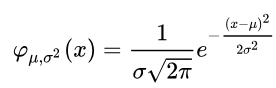

(0.0, 1.0)

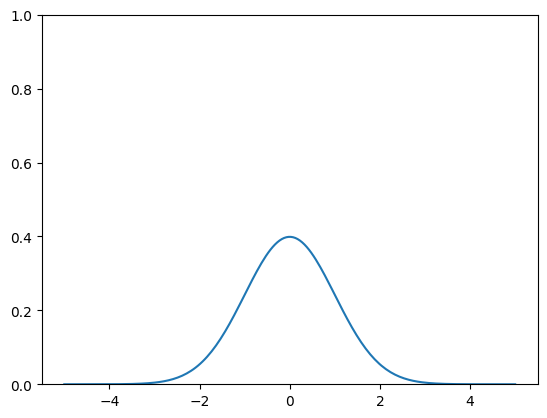

In [ ]:
#Ejemplo, distribucion normal dada la media = 0 y una dt = 1
m = 0
dt = 1
normal = lambda x, m, dt: (1/(dt*sqrt(2*pi)))*e**-(((x-m)**2)/(2*dt**2))
xaxis = np.linspace(-5, 5, 200)
yaxis = [normal(i, m, dt) for i in xaxis]
plt.plot(xaxis, yaxis)
ax = plt.gca()
ax.set_ylim(0, 1)

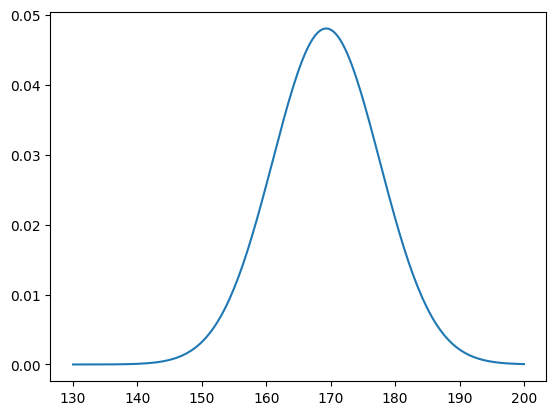

In [ ]:
m = 169.3
dt = 8.3
xaxis = np.linspace(130, 200, 200)
yaxis = [normal(i, m, dt) for i in xaxis]
plt.plot(xaxis, yaxis)

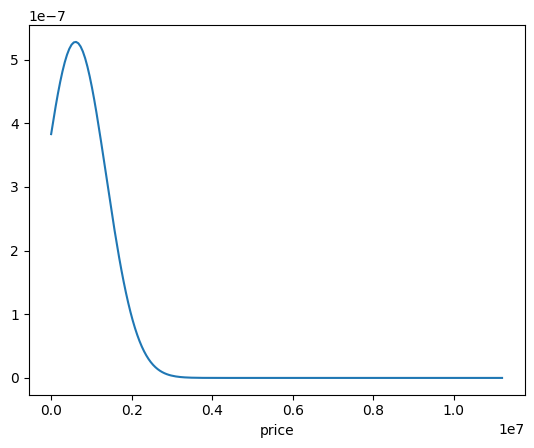

Media: 606305.2682515122


In [ ]:
xaxis = np.linspace(min(data["y"]), max(data["y"]), 200)
yaxis = [normal(i, ymedia, dt_y) for i in xaxis]
plt.plot(xaxis, yaxis)
plt.xlabel("price")
ax.set_xlim(min(data["y"]), max(data["y"]))
plt.show()
print(f"Media: {ymedia}")

Los datos de los precios de la vivienda en madrid parecen no seguir una distribucion normal

###Distribucion t-student

###Distribucion chi cuadrado

###Distribucion exponencial

###Distribucion de Pearson

###Distribucion F

###Distribucion multinomial



###Distribucion Categorica

#Gradient descent
El descenso de gradiente o gradiente descendiente es un algoritmo que nos ayuda a ajustar los valores del intercept y pendiente en una recta de regresión de forma que se minimice la suma residual de los cuadrados (rss)

In [ ]:
#Datos inventados
altura = [1.4, 1.9, 3.2]
peso = [0.5, 2.3, 2.9]

def leastSquares(y_real: list, y_predicted: list)-> float:
  ls = 0.0
  for i in range(0, len(y_real)):
    ls += (y_real[i] - y_predicted[i])**2
  return ls

def regPredict(v, intercept, slope):
  return intercept + slope * v


leastSquares(altura, [regPredict(i, 0, 0.64) for i in peso])

3.1559200000000005

La funcion de relacion entre el intercept y la suma residual de los cuadrados es esta:


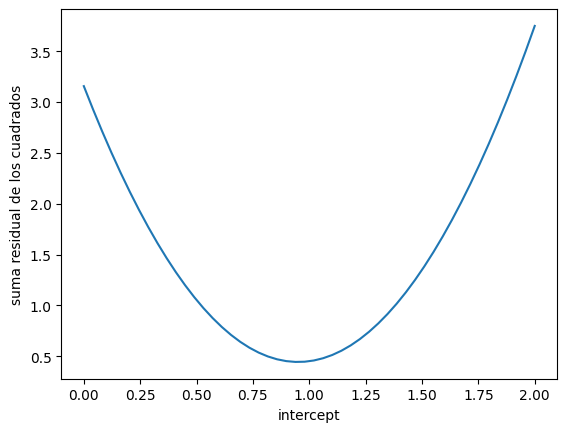

In [ ]:
line = np.linspace(0,2, num = 50)
lineLS_intercept = [leastSquares(altura, [regPredict(j, i, 0.64) for j in peso]) for i in line]
print("La funcion de relacion entre el intercept y la suma residual de los cuadrados es esta:")
plt.plot(line, lineLS_intercept)
plt.xlabel("intercept")
plt.ylabel("suma residual de los cuadrados")
plt.show()

Se puede ver que el intercept que minimiza la suma residual de los cuadrados asumiendo que la pendiente es de 0.64 se encuentra entre 0.90 y 1.

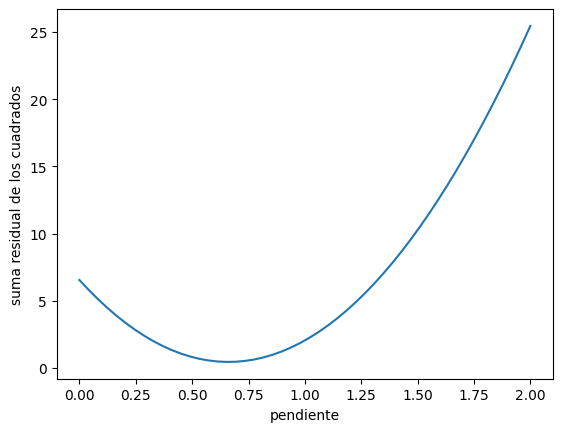

In [ ]:
#Se puede hacer lo mismo con la pendiente, usamos 50 valores homogeneamente repartidos desde 0 a 2 y asumimos que el intercept optimo es 0.9 (no lo es)
lineLS_slope = [leastSquares(altura, [regPredict(j, 0.9, i) for j in peso]) for i in line]
plt.plot(line, lineLS_slope)
plt.xlabel("pendiente")
plt.ylabel("suma residual de los cuadrados")
plt.show()

Asumiendo un intercept de 0.9 podemos ver que la menor suma residual de los cuadrados en funcion de la pendiente se encuentra entre 0.5 y 0.75

Estas dos graficas son muy bonitas pero para realmente verlo bien tendriamos que hacer el gradiente en 3D, que está mas adelante.

##Derivar en Python
Para hacer derivadas podemos usar la funcion derivative(f, x)

f = funcion, hay que pasarle solo el nombre de la funcion

x = Valor para el que queremos averiguar la derivada

Aunque en lo que hacia este documento esa funcion esta en proceso de ser eliminada de scipy, asi que podemos usar una libreria que se llama numdifftools. Esta tiene una funcion que se llama Derivative().

nd.Derivative(f) es un objeto que toma como parametro una funcion (La funcion de la derivada), podemos guardar este objeto como una instancia en una variable u llamar a la variable como si fuera una funcion:

    fun = lambda x: x**2
    d = nd.Derivative(fun)
    print(d(3))

Tambien se pueden hacer parciales si la funcion que le pasamos al objeto toma mas de un argumento.

    fun = lambda x, y: x**2 + y**2
    d = nd.Derivative(fun)
    print(d(3, 4))

El objeto nd.Derivative() puede tambien hacer los calculos con vectores directamente.

In [ ]:
fun = lambda x: x**2
derivtest = nd.Derivative(fun)
derivtest([1,2,3,4])

array([2., 4., 6., 8.])

O incluso con matrices

In [ ]:
fun = lambda x: x**2
derivtest = nd.Derivative(fun)
derivtest([[1,2,3,4],[5,7,8,3],[8,4,2,5]])

array([[ 2.,  4.,  6.,  8.],
       [10., 14., 16.,  6.],
       [16.,  8.,  4., 10.]])

In [ ]:
#Funciones para derivar
def f_intercept(x):
  out = 0
  for i in range(0, len(peso)):
    out += derivative(lambda j: (altura[i]-(j + 0.64 * peso[i]))**2, x)
  return out
print(f_intercept(0))

-5.704000000000001


<ipython-input-118-147fe8531eaa>:5: DeprecationWarning: scipy.misc.derivative is deprecated in SciPy v1.10.0; and will be completely removed in SciPy v1.12.0. You may consider using findiff: https://github.com/maroba/findiff or numdifftools: https://github.com/pbrod/numdifftools
  out += derivative(lambda j: (altura[i]-(j + 0.64 * peso[i]))**2, x)


In [ ]:
#Mucho mejor que lo de arriba es usar numdifftools
fun = lambda x, y: (x-(0 + 0.64 * y))**2
deriv = nd.Derivative(fun)
x = np.array(altura) #Uso arrays de numpy porque las listas de python son un poco mierda
y = np.array(peso)
sum(deriv(x, y)) #Cabe destacar que la funcion usa directamente los arrays como vectores

5.704000000000001

##Plot en 3D del Gradient descent

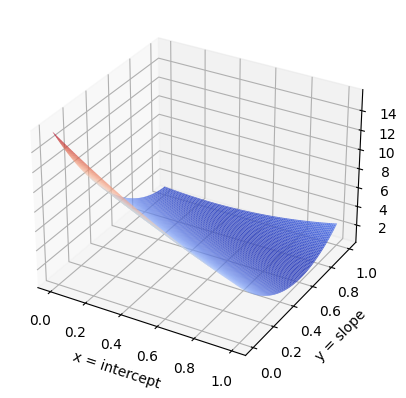

In [ ]:
fig = plt.figure()
ax = plt.axes(projection='3d')   # Create the axes
sampleN = 200 #Numero de muestras que se generan en los espacios lineales, cuanto mas alto mas precision pero tambien mas tiempo de ejecución
# Data
X = np.linspace(0,1, num = sampleN) #Intercept
Y = np.linspace(0,1, num = sampleN) #Slope
Z = np.empty([sampleN, sampleN])
for i in range(0, len(X)):
  for j in range(0, len(Y)):
    Z[i][j] = leastSquares(altura, [regPredict(item, Y[j], X[i]) for item in peso])

X, Y = np.meshgrid(X, Y)
# Plot the 3d surface
surface = ax.plot_surface(X, Y, Z,
                          cmap=cm.coolwarm,
                          rstride = 2,
                          cstride = 2)

# Set some labels
ax.set_xlabel('x = intercept')
ax.set_ylabel('y = slope')
ax.set_zlabel('rss')

plt.show()

In [ ]:
minIdx = np.where(Z == Z.min())
minIdx = [minIdx[0][0], minIdx[1][0]]
print(  f"""La minima suma residual de los cuadrados encontrada es de {Z.min()} en el índice {minIdx}
        con una pendiente de {Y[minIdx[0]][minIdx[1]]} y un intercept de {X[minIdx[0]][minIdx[1]]}""")

La minima suma residual de los cuadrados encontrada es de 0.4446304386252875 en el índice [128, 188]
        con una pendiente de 0.6432160804020101 y un intercept de 0.9447236180904522


In [ ]:
#Comprobación
print(leastSquares(altura ,[regPredict(i, X[minIdx[0]][minIdx[1]], Y[minIdx[0]][minIdx[1]]) for i in peso]))
"""print("Los minimos de cada vector dentro de Z son:")
for i in Z: #Lo comento porque da mucho texto
  print(min(i))"""

0.4446304386252875


'print("Los minimos de cada vector dentro de Z son:")\nfor i in Z: #Lo comento porque da mucho texto\n  print(min(i))'

Los resultados no son del todo precisos pero se acercan bastante, el intercept debería ser de 0.95 y la pendiente de 0.64.

Al fin y al cabo no he usado una estimación por derivadas de verdad sino que he creado matrices con los valores de intercept y pendiente y los he combinado para crear otra matriz de los resultados de la suma residual de los cuadrados con cada elemento dentro de esas matrices, lo he hecho por fuerza bruta. Esto quiere decir que cuanto mas reduzcamos la distancia entre cada valor en las matrices mas preciso es pero tambien tarda mas en procesar. Sería mas preciso si aumentamos la cantidad de valores que toman los espacios lineales de numpy y el tamaño de las matrices.

Voy a probar ahora a hacer lo mismo pero con datos reales y no inventados. El codigo que he hecho arriba esta bien cuando tienes pocos datos pero es lentisimo para los datos reales con 16000 muestras asi que habría que adaptarlo para hacer los calculos directamente con matrices.

0.4446304386252875


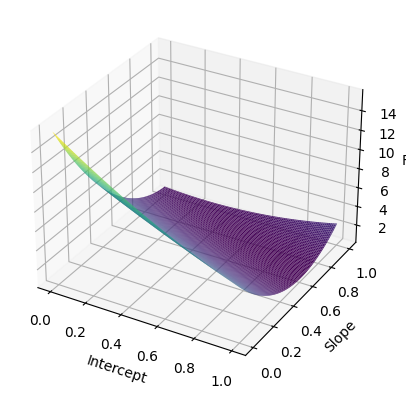

In [ ]:
model = LeastSquaresGradient(peso, altura, 0, 1, 0, 1, accuracy=200)
print(model.ls.min())
model.print_3d_graph()

In [ ]:
fig = plt.figure()
ax = plt.axes(projection='3d')   # Create the axes
sampleN = 100 #Numero de muestras que se generan en los espacios lineales, cuanto mas alto mas precision pero tambien mas tiempo de ejecución
# Data
X = np.linspace(a-2*a,a*3, num = sampleN) #Intercept
Y = np.linspace(b-2*b,b*3, num = sampleN) #Slope
Z = np.empty([sampleN, sampleN])

for i in range(0, len(X)):
  for j in range(0, len(Y)):
    Z[i][j] = leastSquares(data["y"], [regPredict(item, Y[j], X[i]) for item in data["x"]])

X, Y = np.meshgrid(X, Y)
# Plot the 3d surface
surface = ax.plot_surface(X, Y, Z,
                          cmap=cm.coolwarm,
                          rstride = 2,
                          cstride = 2)

# Set some labels
ax.set_xlabel('x = intercept')
ax.set_ylabel('y = slope')
ax.set_zlabel('rss')

plt.show()

Usando un coigo similar al de arriba ha tardado 10 minutos en ejecutarse asi que lo he reescrito usando una clase para que sea mas polivalente y con operaciones de matrices para que sea mas optimo. La clase está arriba del todo del documento.

In [ ]:
minIdx = np.where(Z == Z.min())
minIdx = [minIdx[0][0], minIdx[1][0]]
print(  f"""La minima suma residual de los cuadrados encontrada es de {Z.min()} en el índice {minIdx}
        con una pendiente de {Y[minIdx[0]][minIdx[1]]} y un intercept de {X[minIdx[0]][minIdx[1]]}""")

In [ ]:
#print(Z[1][16])
print("Los minimos de cada vector dentro de Z son:")
for i in Z: #Lo comento porque da mucho texto
  print(min(i))

Ahora voy a probar con la clase que he creado para ver cuanta diferencia hay en tiempo de ejecución.

2551746995006602.0


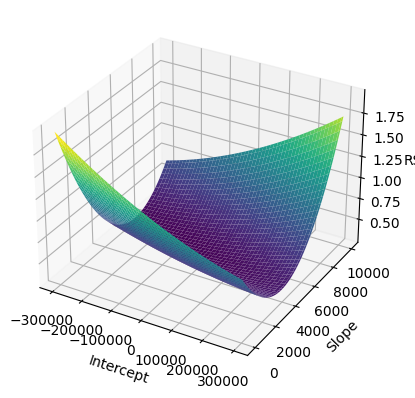

In [ ]:
model = LeastSquaresGradient(data["x"], data["y"], -300000, 300000, 0, 10000, accuracy=100)
print(model.ls.min())
model.print_3d_graph()

In [ ]:
minIdx = np.where(model.ls == model.ls.min())
minInter = model.intercept[0][minIdx[1][0]]
minSlope = model.slope[minIdx[0][0]][0]
print(f"""
      Error minimo con la formula: {rss_y}\n
      Error minimo: {model.ls.min()}\n
      Diferencia en el error minimo: {((model.ls.min()-rss_y)/rss_y)*100}%\n
      Intercept minimo: {minInter}\n
      Pendiente minima: {minSlope}
      """)
#print(sum((np.array(data["y"])-(minInter + minSlope * np.array(data["x"])))**2)) #Esta linea es solo para comprobar que los datos son los correctos